In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
tops = pd.read_csv(r"clean_teapot.csv", index_col=[0]) #read in the top data
tops.head()

API Formation       MD       SS
45  490251022100      F2WC  2626.64  2398.36
46  490251022100  F1WCbase  2237.94  2787.06
47  490251022100        B1  2446.59  2578.41
48  490251022100      F1WC  2210.40  2814.60
49  490251040300     SHNNu   389.69  4781.31

In [8]:
ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values

tops.dropna(inplace=True)

def sample_splitter(dataframe, fraction, randomseed):
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train =  dataframe.drop(test_idx)
    return train, test

train, test = sample_splitter(tops, 0.2, 86)

print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
R = D_df.values
from sklearn.preprocessing import binarize
A = binarize(R) 


In [244]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    #print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    #print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
     #   print(
     #       "Error after solving for User Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
     #   print(
     #       "Error after solving for Item Matrix:",
     #       get_error(A, Users, Items, R),
     #   )

        MSE_List.append(get_error(A, Users, Items, R))
     #   print("%sth iteration is complete..." % iter)
    
   # print(MSE_List)
   # fig = plt.figure()
   # ax = fig.add_subplot(111)
   # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
   # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    return Users, Items

In [10]:
U, Vt = runALS(R, A, 3, 20, 0.1)

recommendations = np.dot(U, Vt) #get the recommendations

recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

newDF = recsys.T
newDF.reset_index(inplace=True)

flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

new_df.rename(columns={0:'SS_pred'}, inplace=True)

cleanDF = new_df.dropna()

cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])


from sklearn.metrics import mean_absolute_error as MSE
print(MSE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

Initiating 
11.557948275725506


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


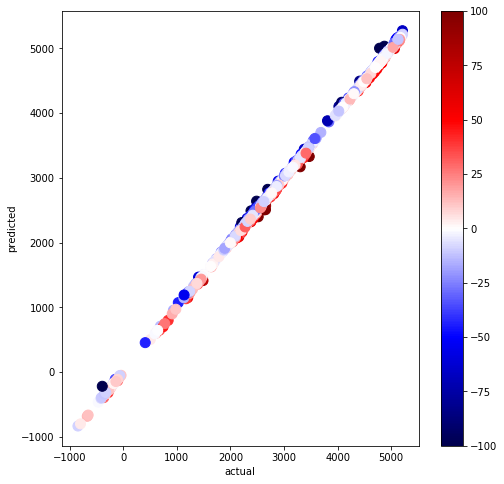

In [11]:
plt.figure(figsize=(8,8))
plt.scatter(cleanDF.SS+ssmin, cleanDF.SS_pred+ssmin, c=cleanDF.signed_error, vmin=-100,vmax=100, cmap='seismic', s=100)
plt.plot()
plt.xlabel('actual')
plt.ylabel('predicted')
plt.colorbar()

In [12]:
well_locs = pd.read_csv(r'TeapotDomeWellHeaders.csv')
well_locs.rename(columns={'API Number':'API'}, inplace=True)

In [13]:
locationDF = cleanDF.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

In [14]:
strat_order = ['SSXS', 'SSXbase','SHNNu', 'SHNNl','SHNNbs','StBR','StFT','StGD','StAM','NBRR','NBRRws','NBRRsg','CRLL',
                'F1WC','F2WC',
'F3WC',
'MWRY',
'MDDY',
'THRM',
'DKOT',
'LKOT',
'MRNS',
'SNDCu',
'STBV',
'CNSP',
'SNDCl',
'GPSP',
'CRMT'	,
'ALCV',
'RDPK'	,
'GSEG',
'ERVY',
'FRLL',
'GLND',
'MNKT',
'OPCH',
'A Sand',
'B Dolo',
'B Sand',
'C1 Dolo',
'C1 Sand',
'C2 Dolo',
'C2 Sand',
'C3 Dolo',
'C3 Sand',
'C4 Dolo',
'C4 Sand',
'D Dolo',
'D Sand',
'E Dolo',
'AMSD',
'MDSN',
'PC',
]

In [15]:
for formation in strat_order:
    form = locationDF[locationDF['Formation'] == formation]
    try:
        print(str(formation)+' mean absolute error is '+str(MSE(form.SS.values-ssmin, form.SS_pred.values-ssmin)))
    except:
        print(str(formation)+' has no holdout samples')

SSXS mean absolute error is 5.143938173032984
SSXbase mean absolute error is 10.407964101224522
SHNNu mean absolute error is 7.550437272648311
SHNNl mean absolute error is 5.591678571749169
SHNNbs mean absolute error is 7.093129534647782
StBR mean absolute error is 12.096611860186659
StFT mean absolute error is 19.42962703599302
StGD mean absolute error is 26.340786461154742
StAM mean absolute error is 10.974679566930051
NBRR has no holdout samples
NBRRws mean absolute error is 14.045215440425272
NBRRsg mean absolute error is 9.901745427558211
CRLL mean absolute error is 12.278028135505762
F1WC mean absolute error is 10.56146978581901
F2WC mean absolute error is 9.98840329844962
F3WC mean absolute error is 9.66433809568656
MWRY mean absolute error is 8.207317023432147
MDDY mean absolute error is 16.23270910557806
THRM mean absolute error is 10.381066142327835
DKOT mean absolute error is 18.44589021713291
LKOT mean absolute error is 15.783819306577547
MRNS has no holdout samples
SNDCu m

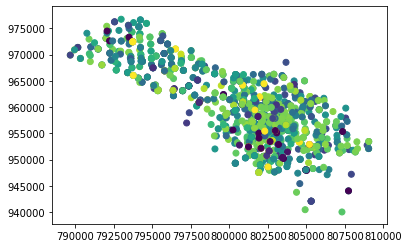

In [16]:
for formation in strat_order:
    subset = locationDF[locationDF['Formation'] == formation]
    plt.scatter(subset.Easting, subset.Northing, c=subset.signed_error)

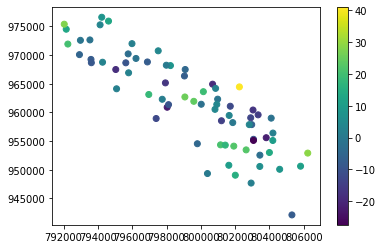

In [22]:
subset = locationDF[locationDF['Formation'] == 'F1WC']
plt.scatter(subset.Easting, subset.Northing, c=subset.signed_error)
plt.colorbar()

In [64]:
locationDF_full = tops.merge(well_locs[['Northing', 'Easting', 'API']], on='API')
predictions = flat_preds.merge(well_locs[['Northing', 'Easting', 'API']], on='API')

locationDF_full.Formation.unique()

array(['F2WC', 'F1WCbase', 'B1', 'F1WC', 'SHNNu', 'SHNNl', 'CRLL',
       'SHNNbs', 'SSXbase', 'NBRRsg', 'NBRRws', 'F1WCBench1Base',
       'F1WCBench2Top', 'F1WCBench2Base', 'F1WCBench3Top', 'F2WCbase',
       'SSXS', 'A Sand', 'B Dolo', 'B Sand', 'C1 Dolo', 'MNKT', 'OPCH',
       'StBR', 'StFT', 'StAM', 'StGD', 'F3WC', 'F3WCbase', 'DKOT', 'MDDY',
       'MWRY', 'THRM', 'LKOT', 'MRSN', 'ALCV', 'LAKev', 'CRMT', 'LAKss',
       'CNSP', 'FRLL', 'StTC', 'SNDCu', 'RDPK', 'ERVY', 'C2 Sand',
       'C3 Dolo', 'C3 Sand', 'C4 Dolo', 'C4 Sand', 'TensleepFluidLevel',
       'D Dolo', 'C1 Sand', 'C2 Dolo', 'E Dolo', 'D Sand', 'GLND', 'PC',
       'MDSN', 'AMSD'], dtype=object)

(940000, 978000)

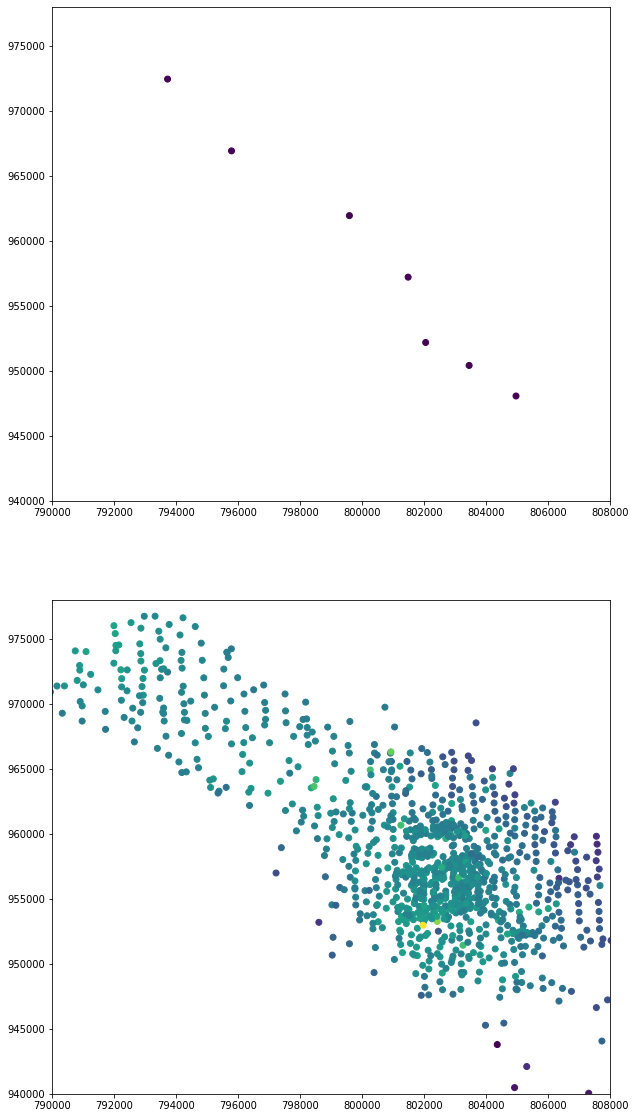

In [135]:
subset = locationDF_full[locationDF_full['Formation'] == 'SNDCu']
subpreds = predictions[predictions['Formation'] == 'SNDCu']
fig, ax = plt.subplots(2,1, figsize=(10,20))
ax[0].scatter(subset.Easting, subset.Northing, c=subset.SS, cmap='viridis', vmin=5000, vmax=7000)
ax[0].set_xlim(790000, 808000)
ax[0].set_ylim(940000, 978000)

ax[1].scatter(subpreds.Easting, subpreds.Northing, c=subpreds[0], cmap='viridis')#, vmin=-1500, vmax=3000)
ax[1].set_xlim(790000, 808000)
ax[1].set_ylim(940000, 978000)


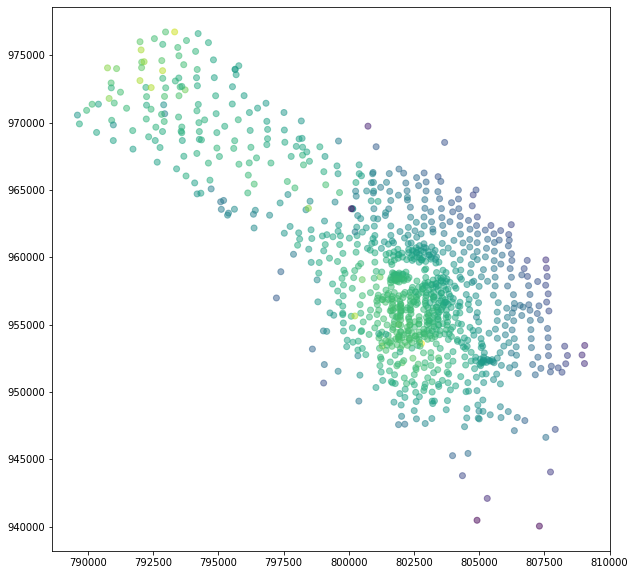

<Figure size 432x288 with 0 Axes>

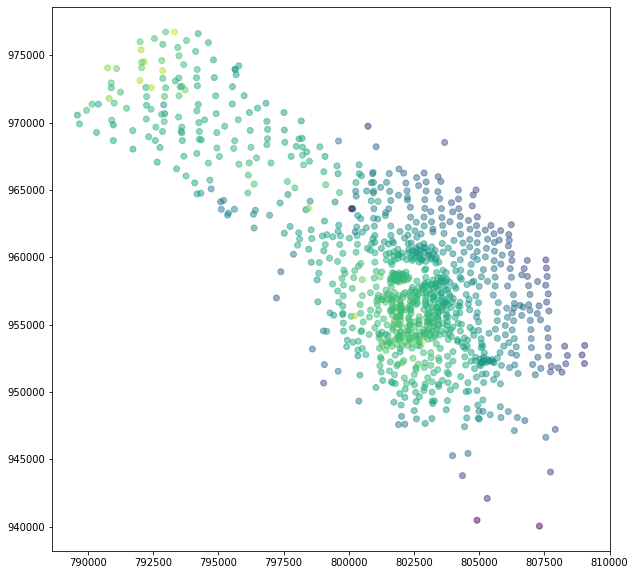

<Figure size 432x288 with 0 Axes>

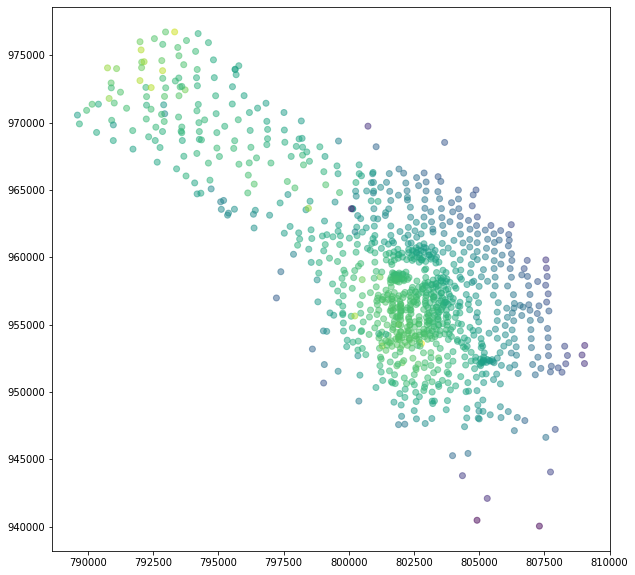

<Figure size 432x288 with 0 Axes>

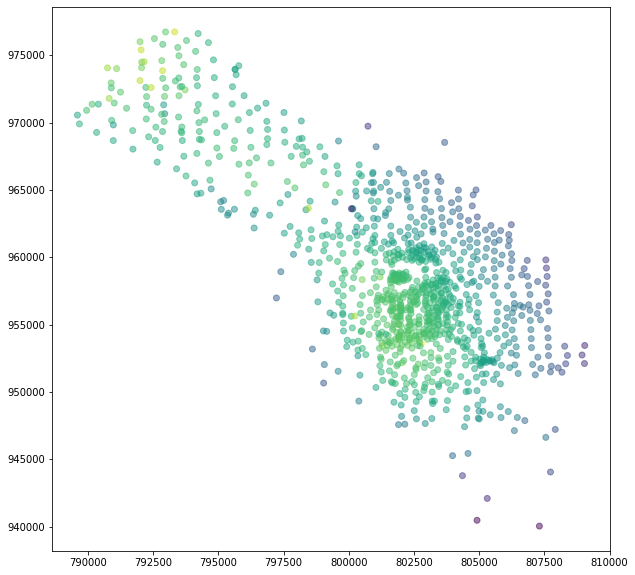

<Figure size 432x288 with 0 Axes>

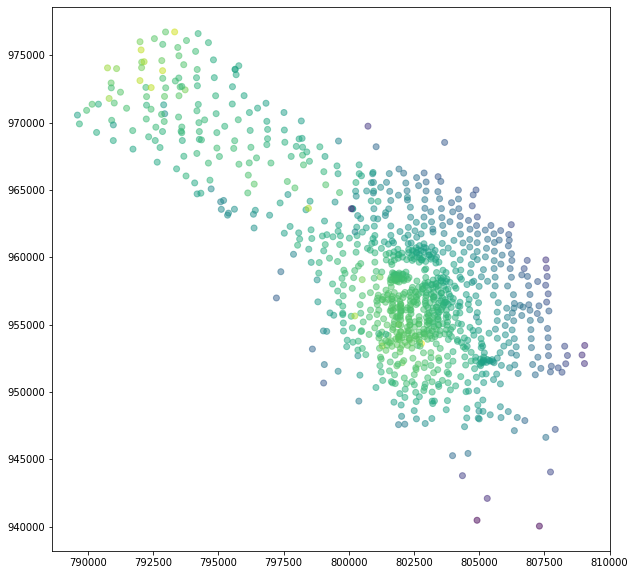

<Figure size 432x288 with 0 Axes>

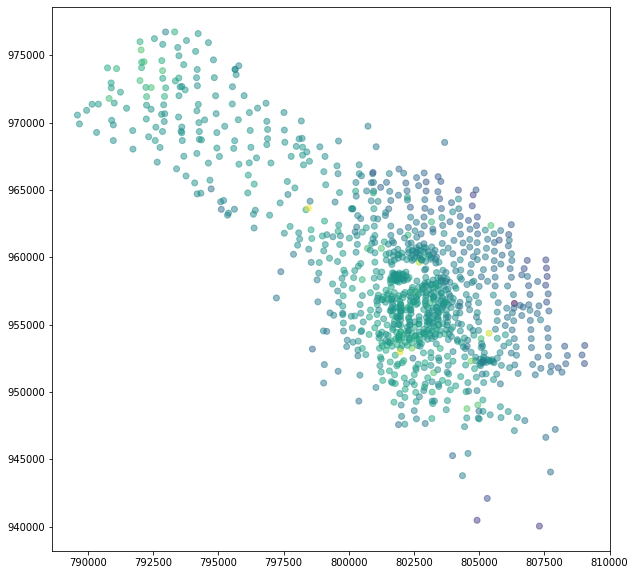

<Figure size 432x288 with 0 Axes>

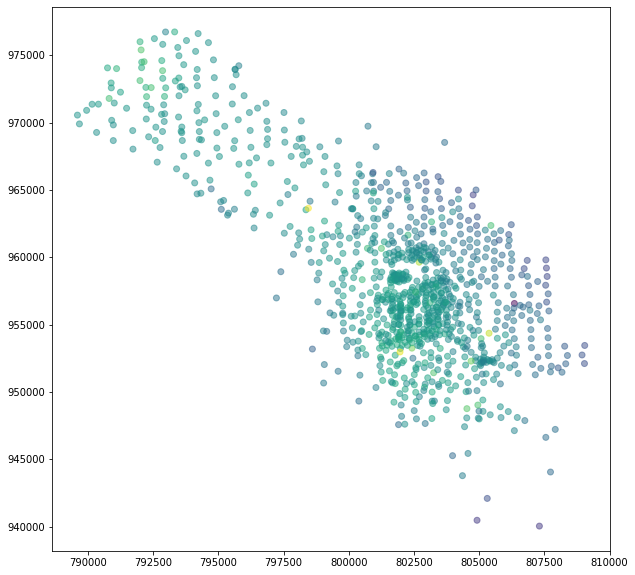

<Figure size 432x288 with 0 Axes>

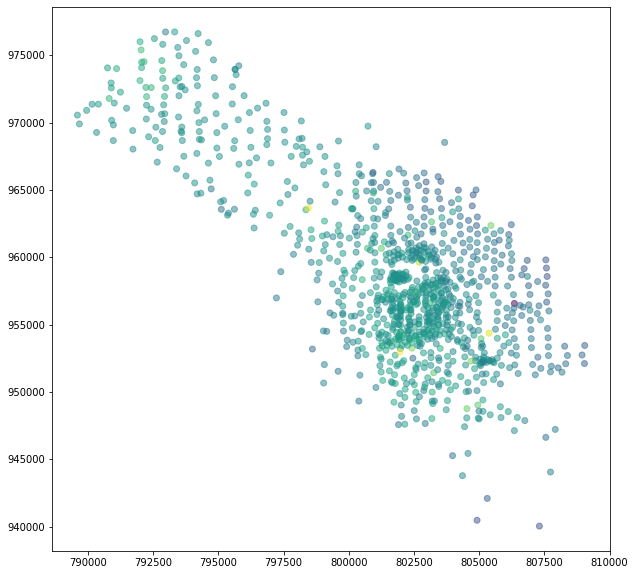

<Figure size 432x288 with 0 Axes>

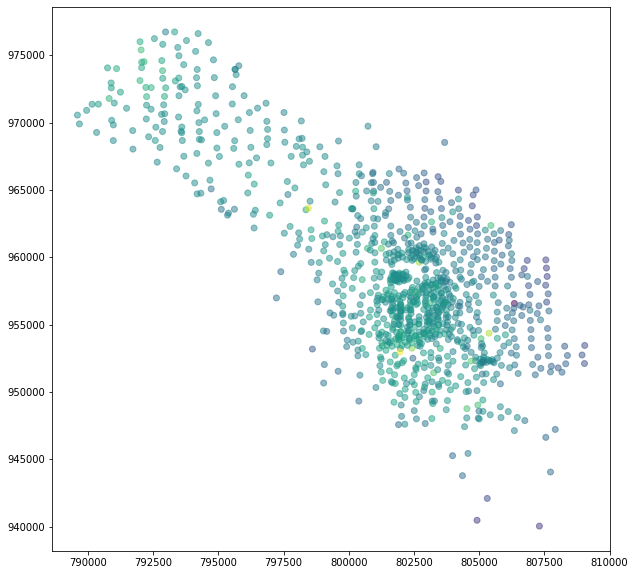

<Figure size 432x288 with 0 Axes>

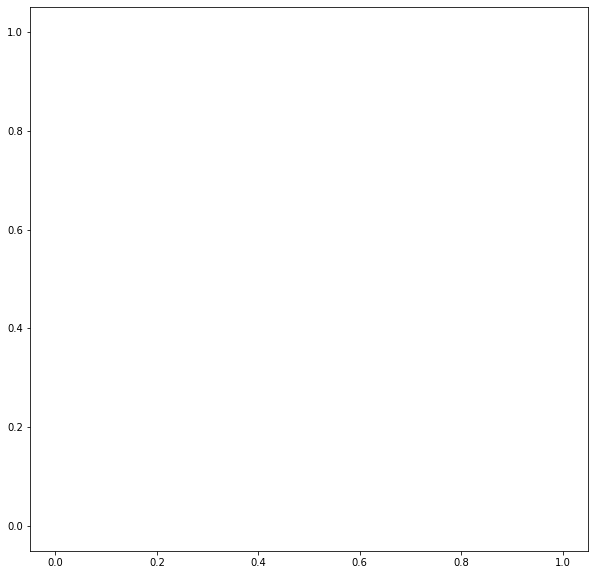

<Figure size 432x288 with 0 Axes>

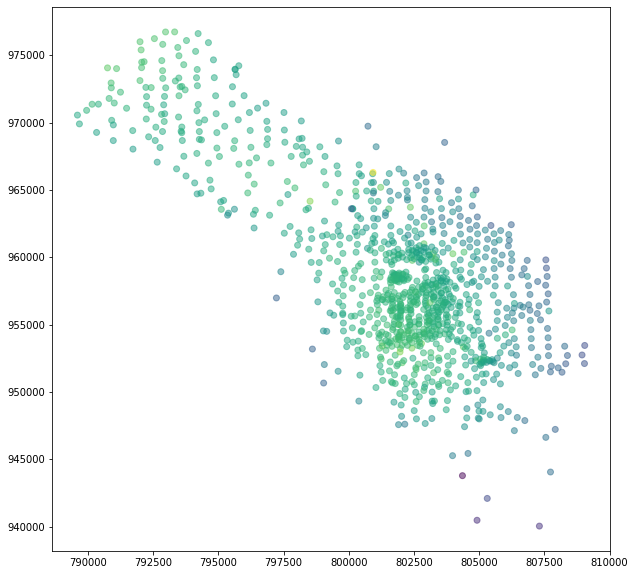

<Figure size 432x288 with 0 Axes>

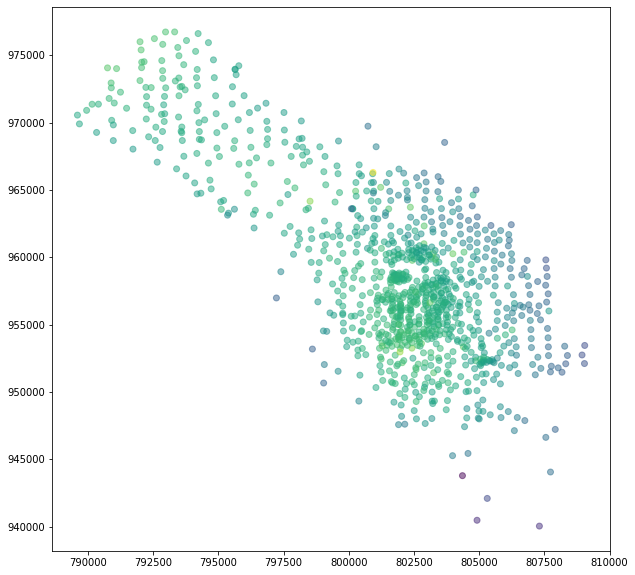

<Figure size 432x288 with 0 Axes>

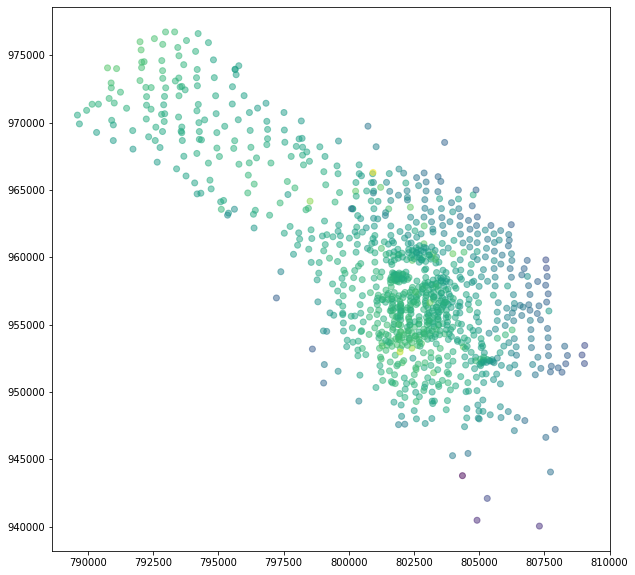

<Figure size 432x288 with 0 Axes>

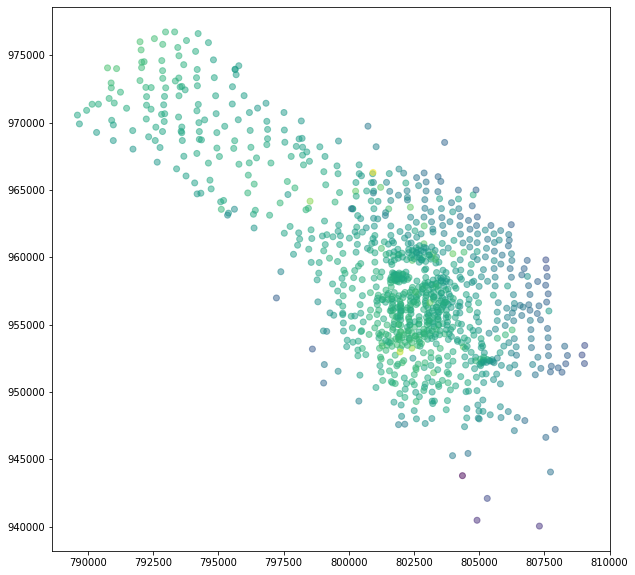

<Figure size 432x288 with 0 Axes>

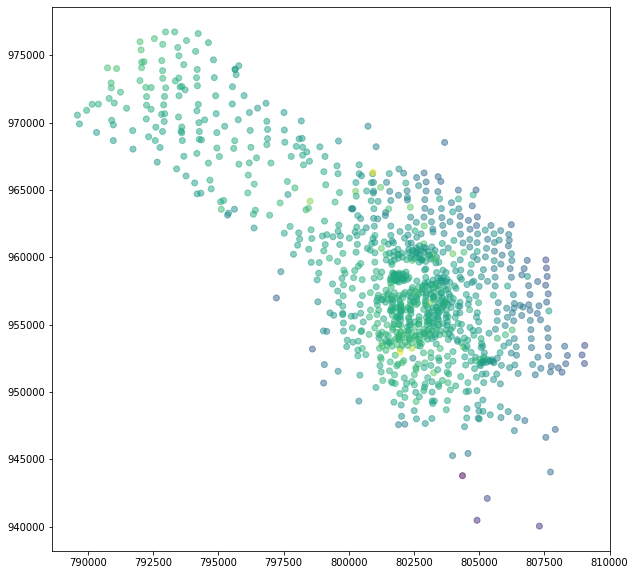

<Figure size 432x288 with 0 Axes>

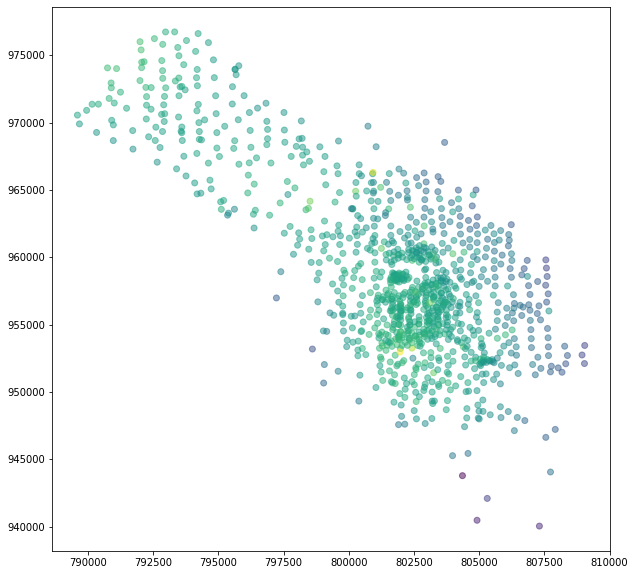

<Figure size 432x288 with 0 Axes>

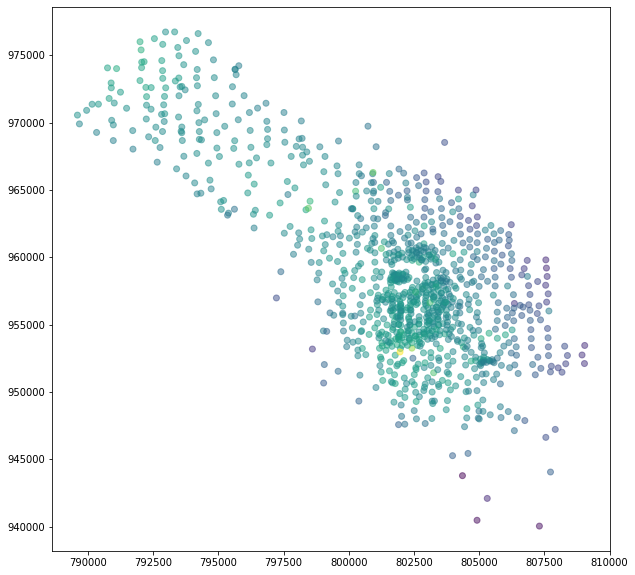

<Figure size 432x288 with 0 Axes>

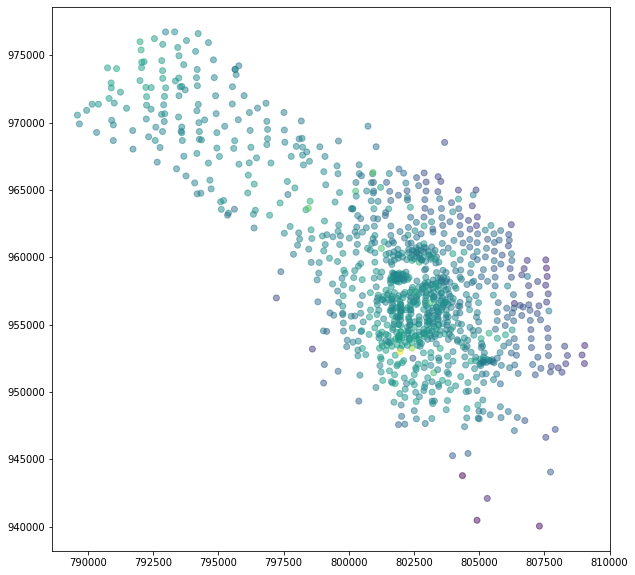

<Figure size 432x288 with 0 Axes>

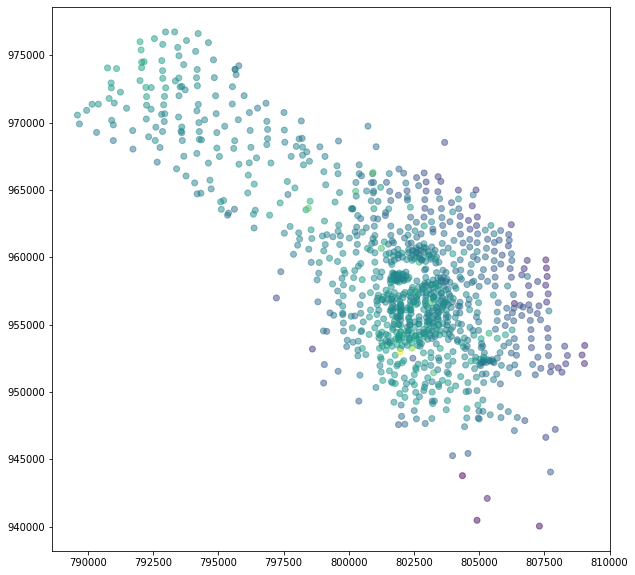

<Figure size 432x288 with 0 Axes>

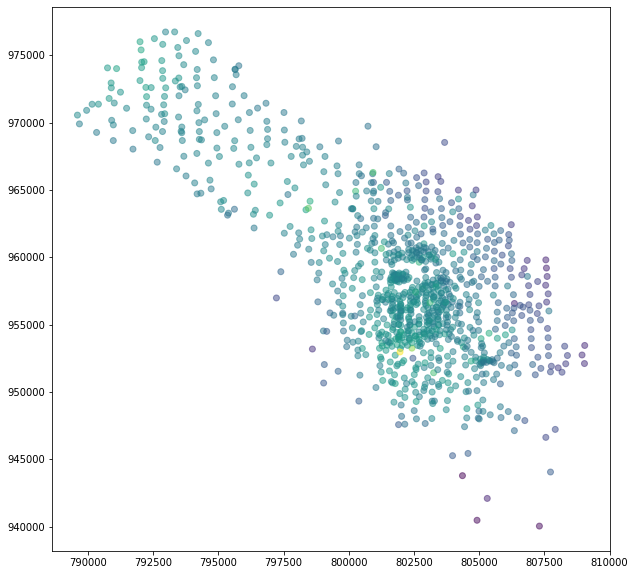

<Figure size 432x288 with 0 Axes>

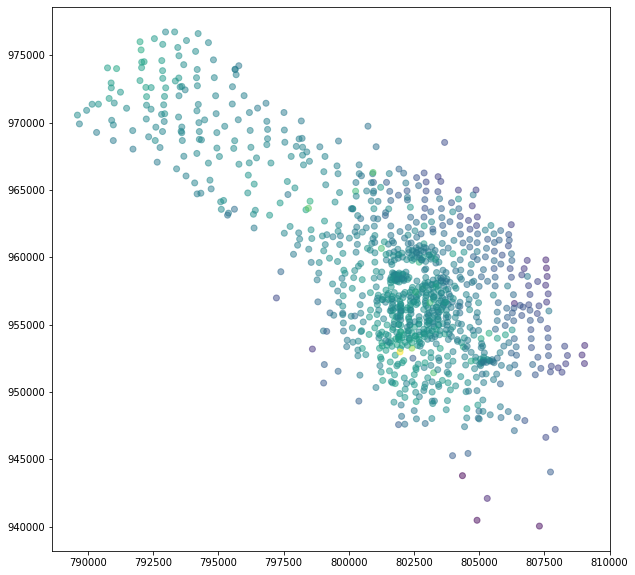

<Figure size 432x288 with 0 Axes>

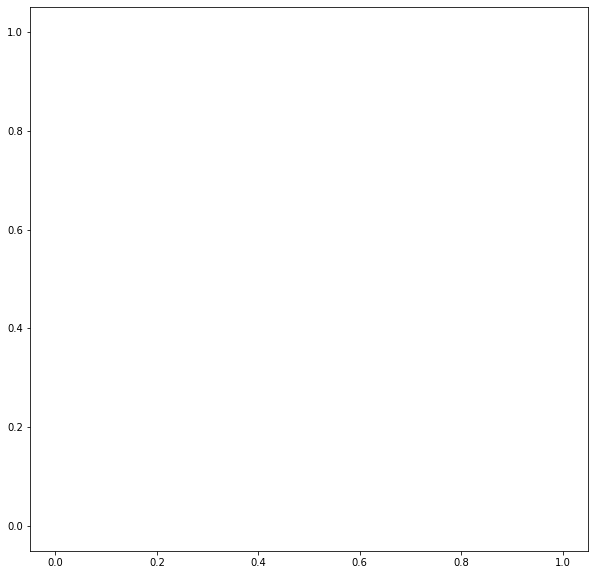

<Figure size 432x288 with 0 Axes>

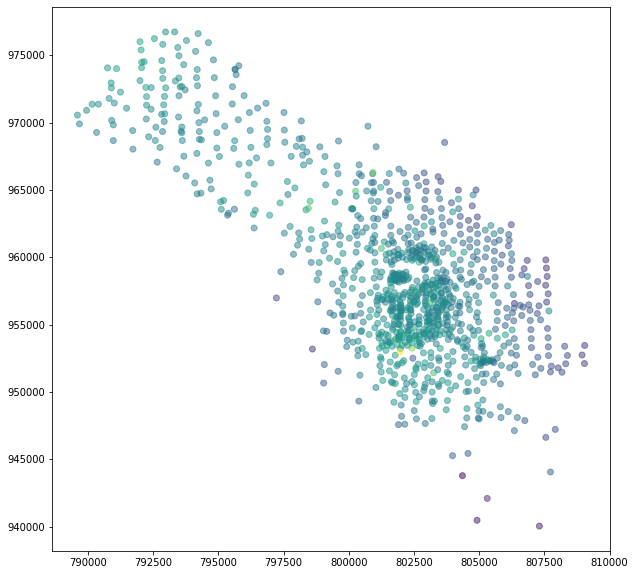

<Figure size 432x288 with 0 Axes>

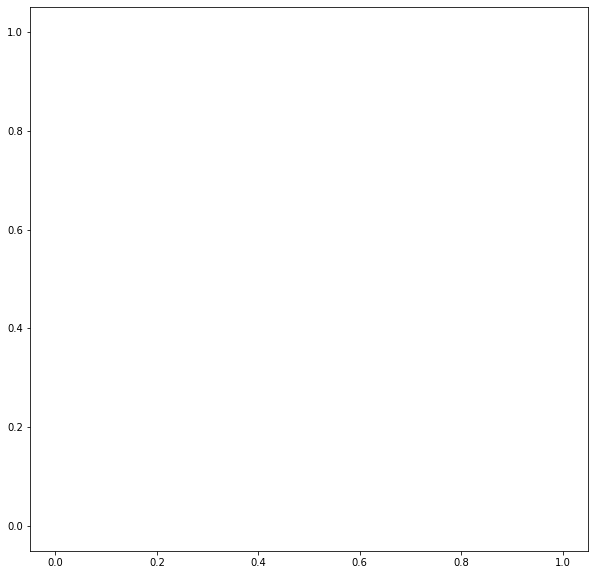

<Figure size 432x288 with 0 Axes>

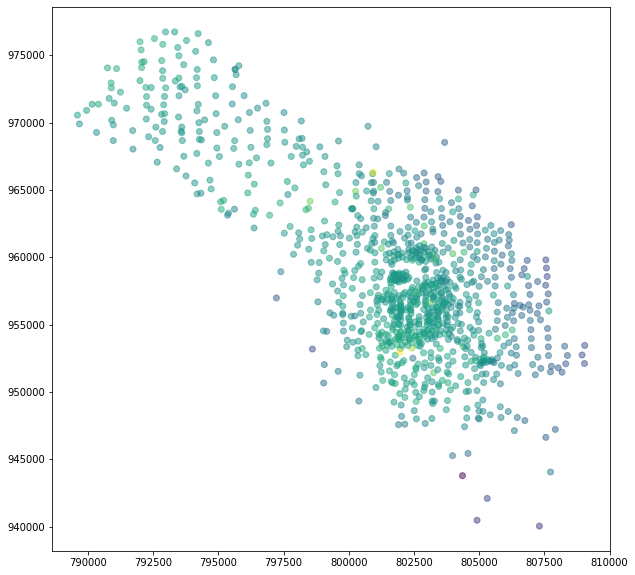

<Figure size 432x288 with 0 Axes>

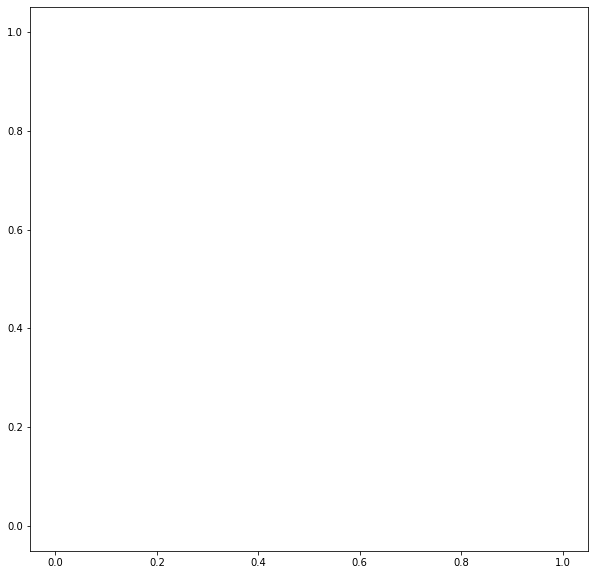

<Figure size 432x288 with 0 Axes>

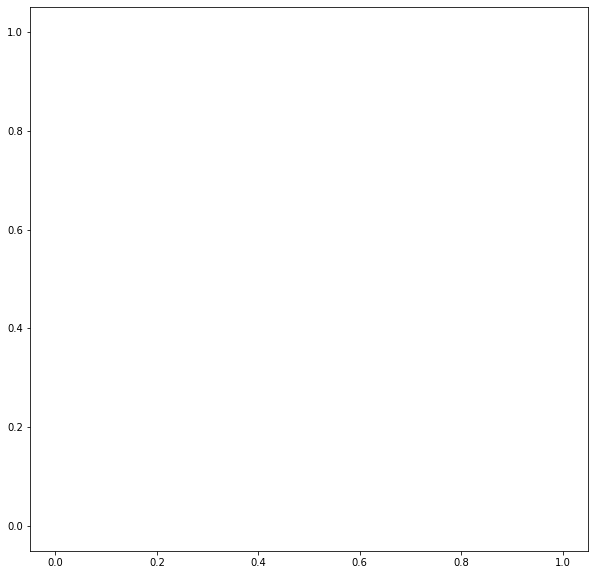

<Figure size 432x288 with 0 Axes>

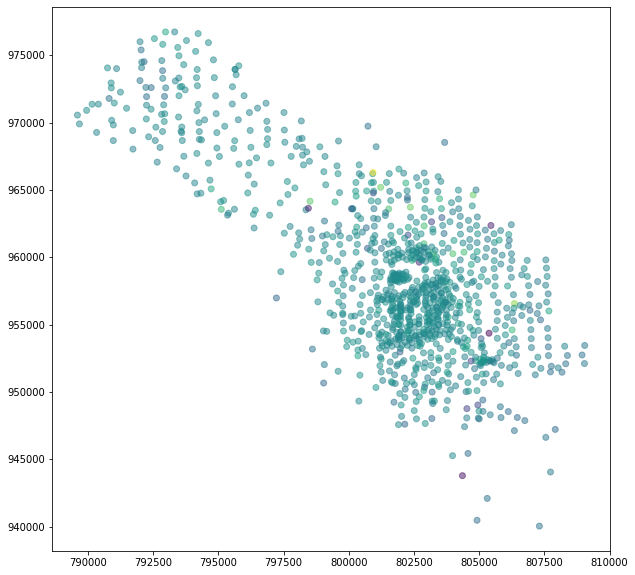

<Figure size 432x288 with 0 Axes>

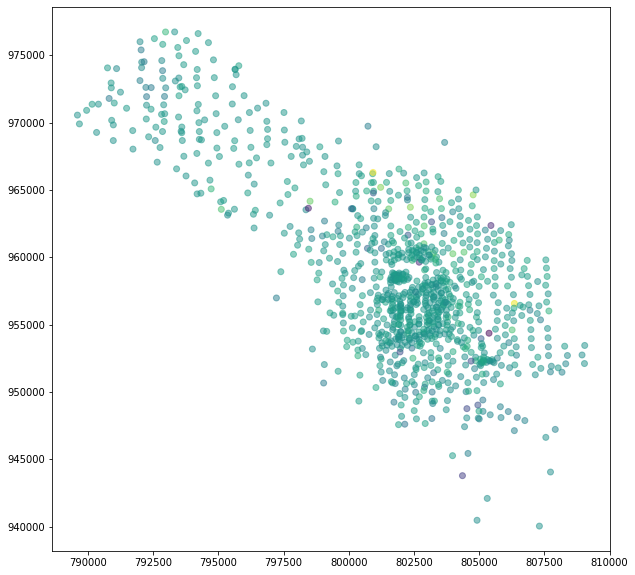

<Figure size 432x288 with 0 Axes>

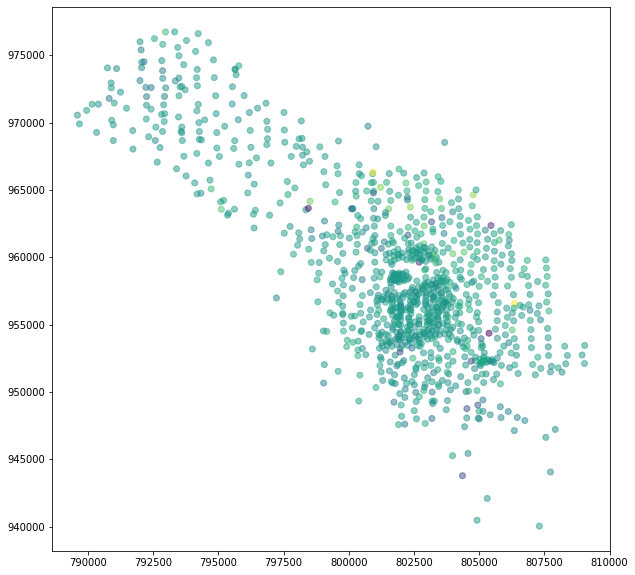

<Figure size 432x288 with 0 Axes>

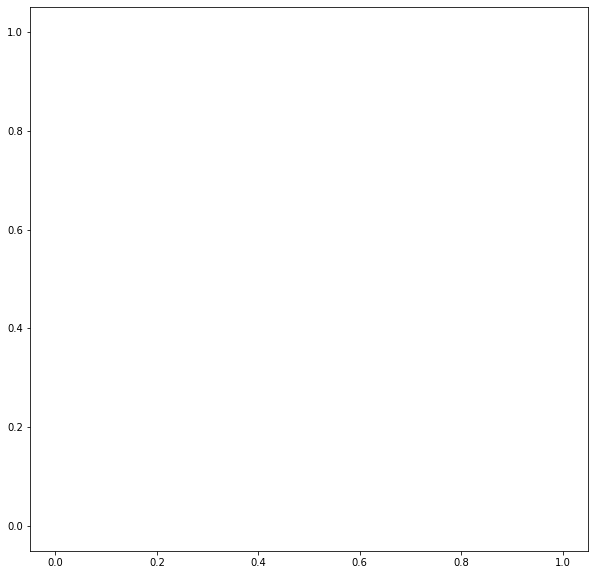

<Figure size 432x288 with 0 Axes>

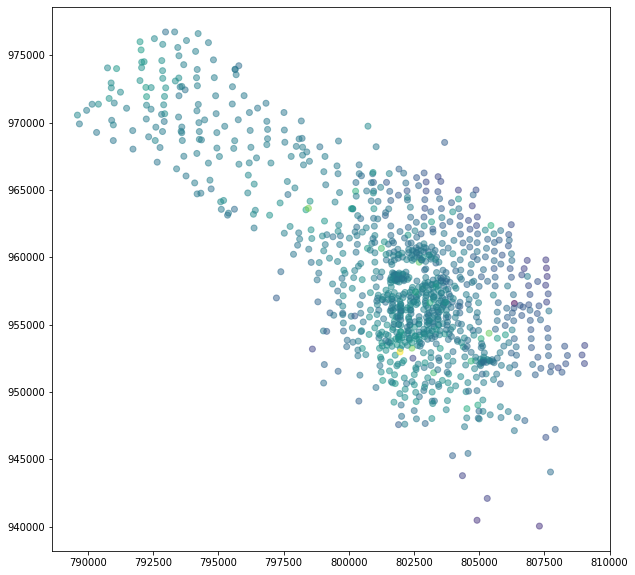

<Figure size 432x288 with 0 Axes>

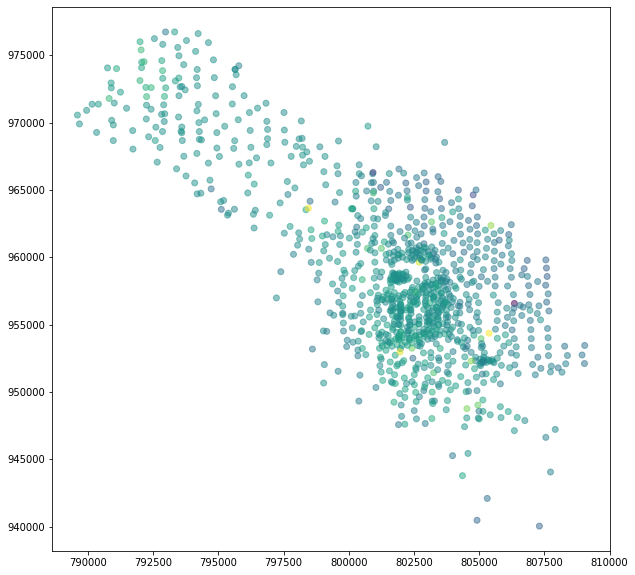

<Figure size 432x288 with 0 Axes>

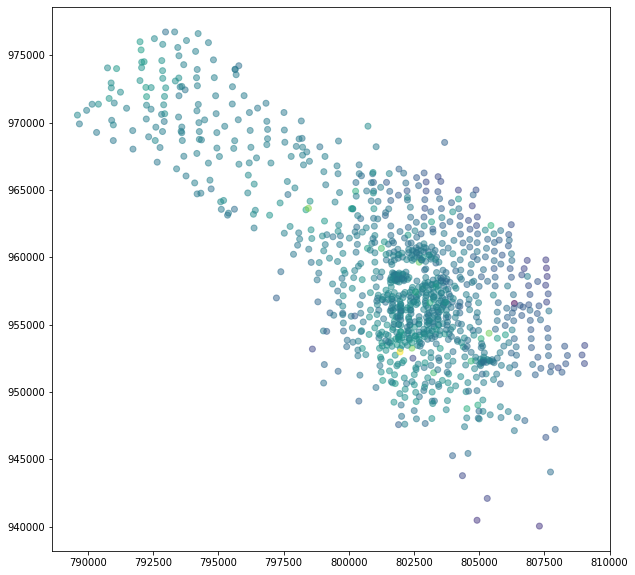

<Figure size 432x288 with 0 Axes>

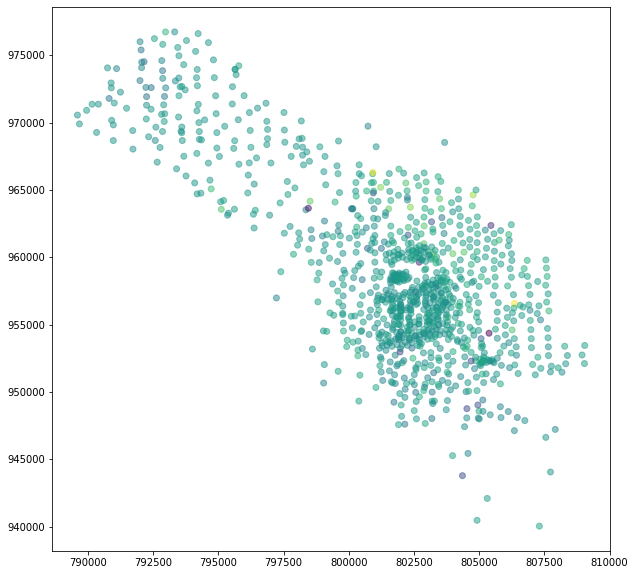

<Figure size 432x288 with 0 Axes>

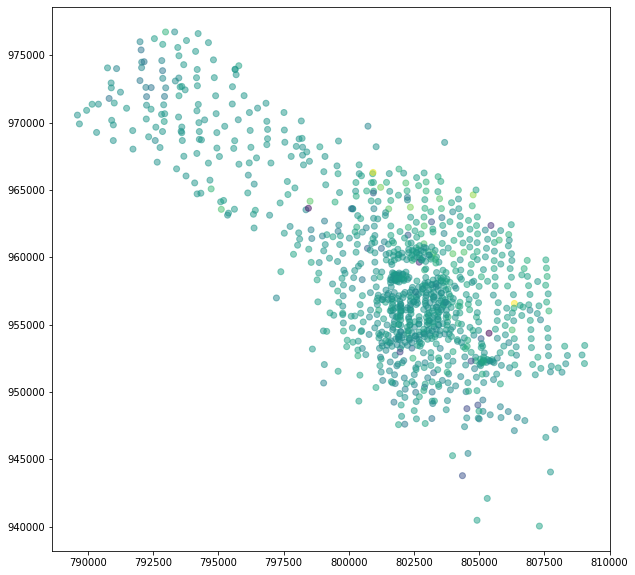

<Figure size 432x288 with 0 Axes>

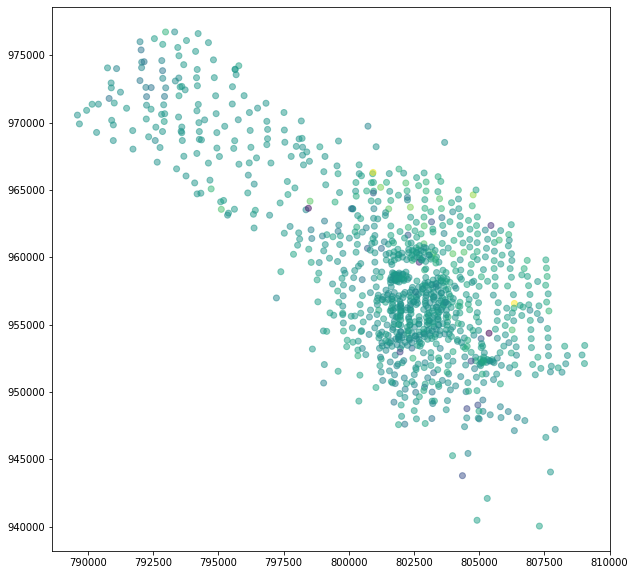

<Figure size 432x288 with 0 Axes>

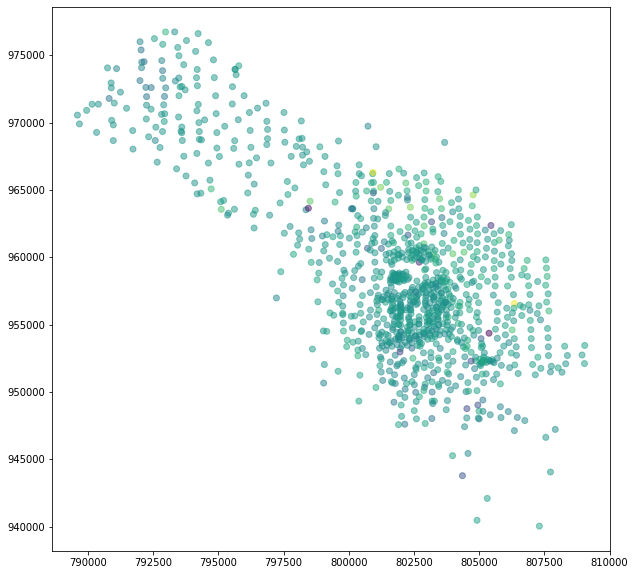

<Figure size 432x288 with 0 Axes>

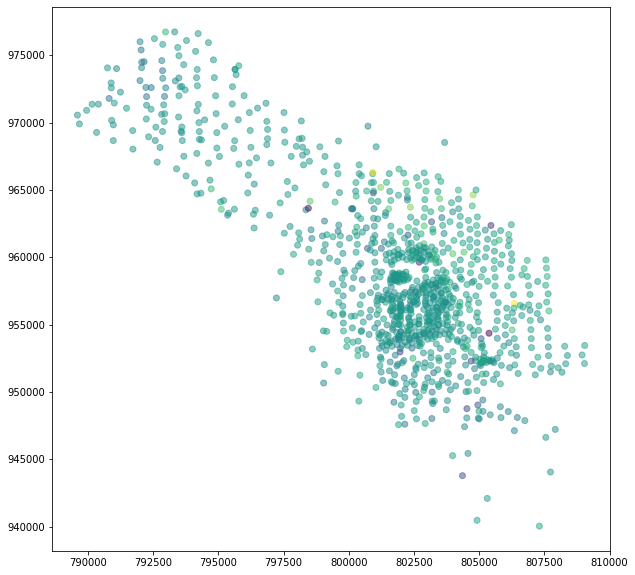

<Figure size 432x288 with 0 Axes>

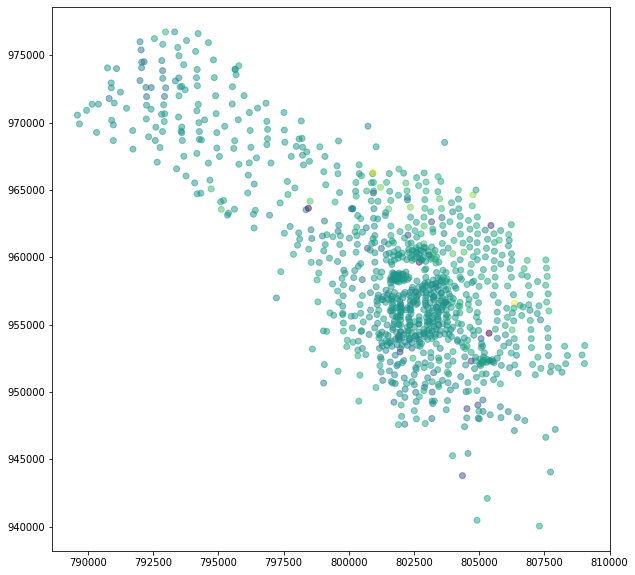

<Figure size 432x288 with 0 Axes>

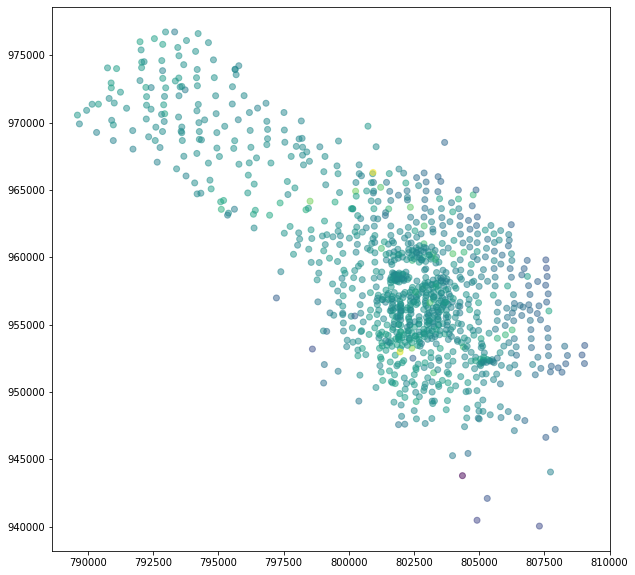

<Figure size 432x288 with 0 Axes>

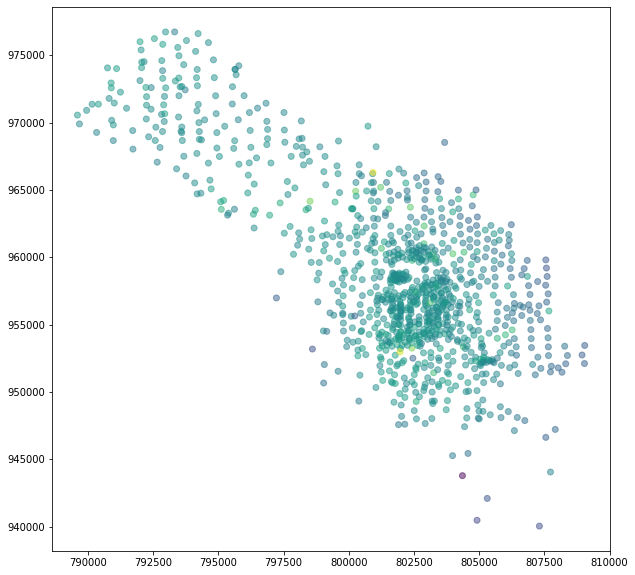

<Figure size 432x288 with 0 Axes>

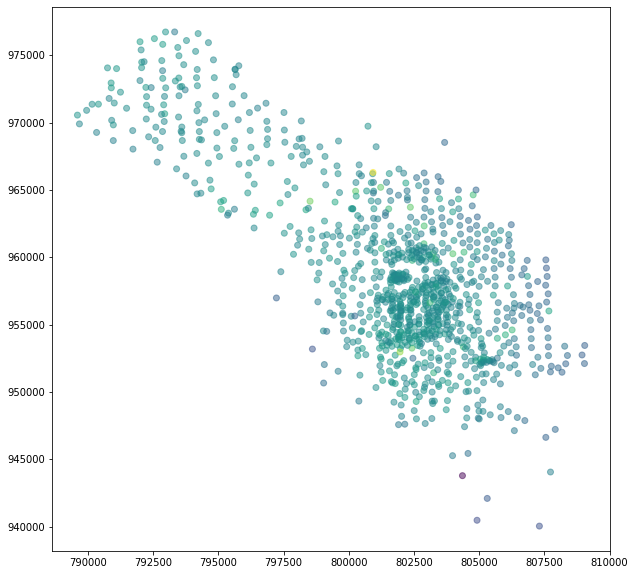

<Figure size 432x288 with 0 Axes>

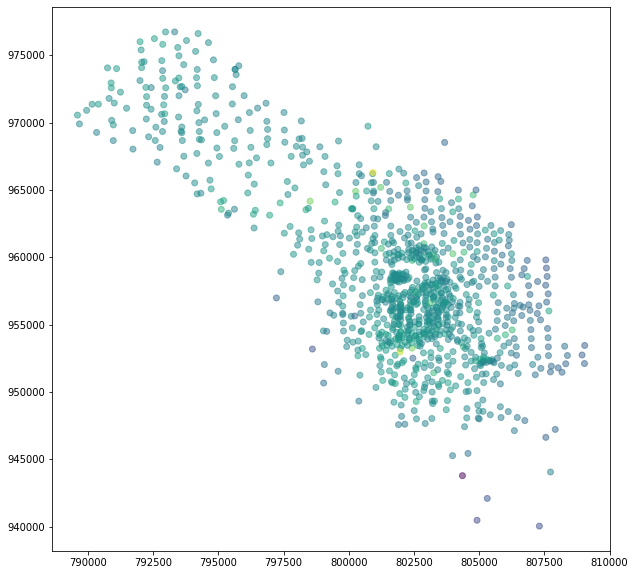

<Figure size 432x288 with 0 Axes>

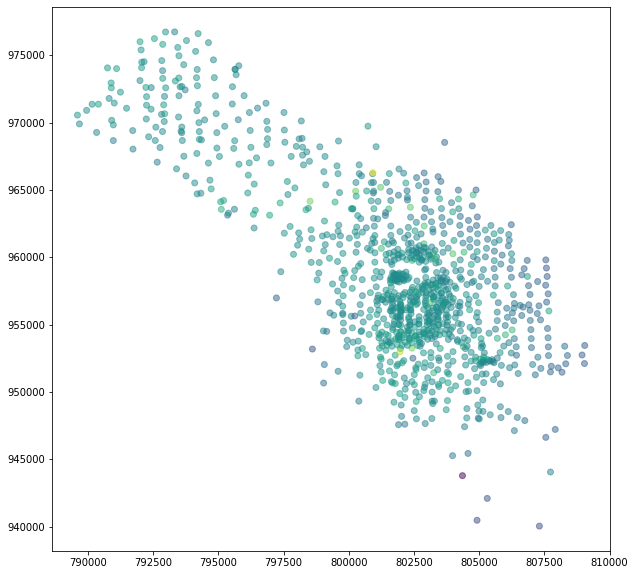

<Figure size 432x288 with 0 Axes>

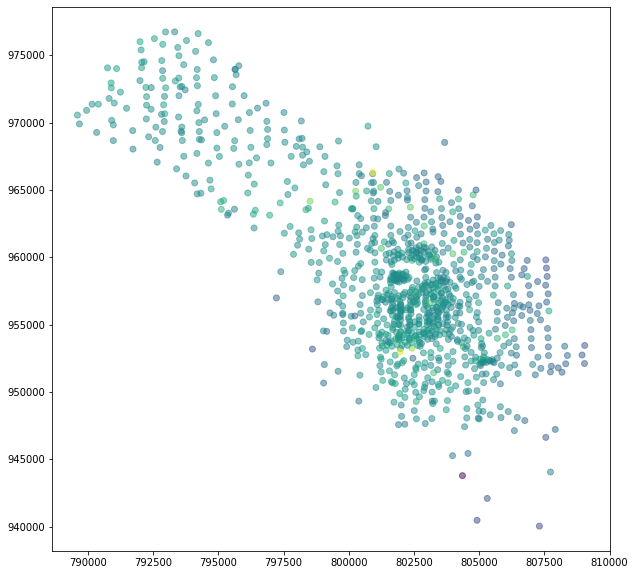

<Figure size 432x288 with 0 Axes>

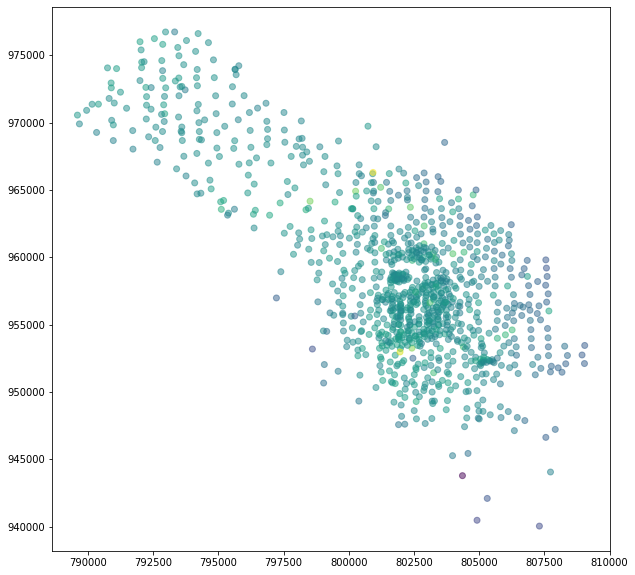

<Figure size 432x288 with 0 Axes>

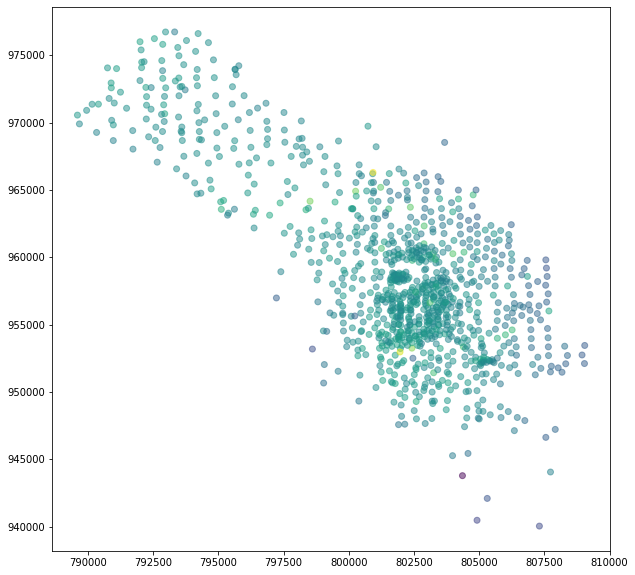

<Figure size 432x288 with 0 Axes>

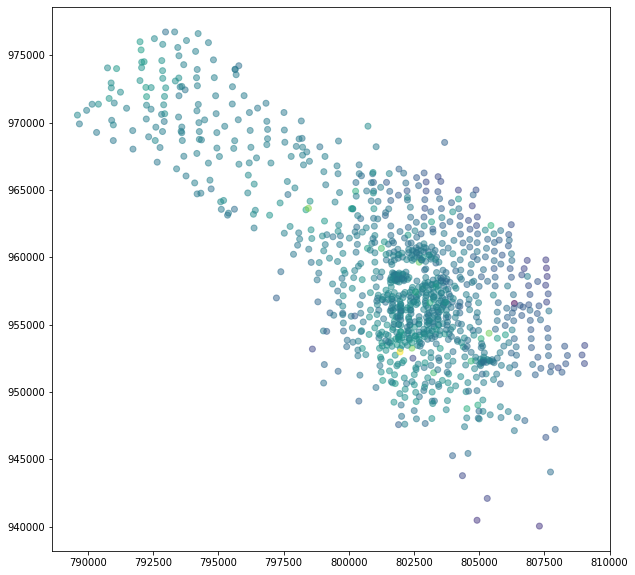

<Figure size 432x288 with 0 Axes>

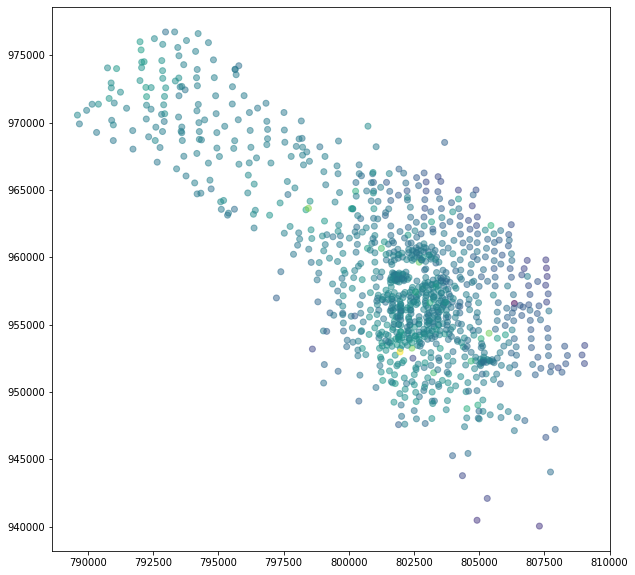

<Figure size 432x288 with 0 Axes>

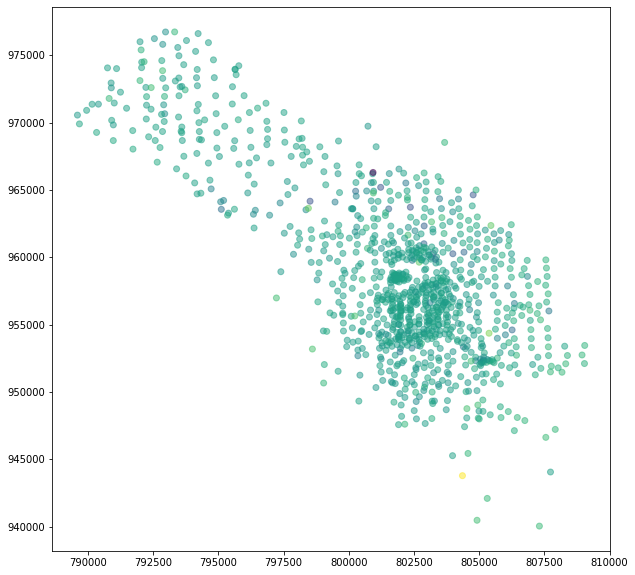

<Figure size 432x288 with 0 Axes>

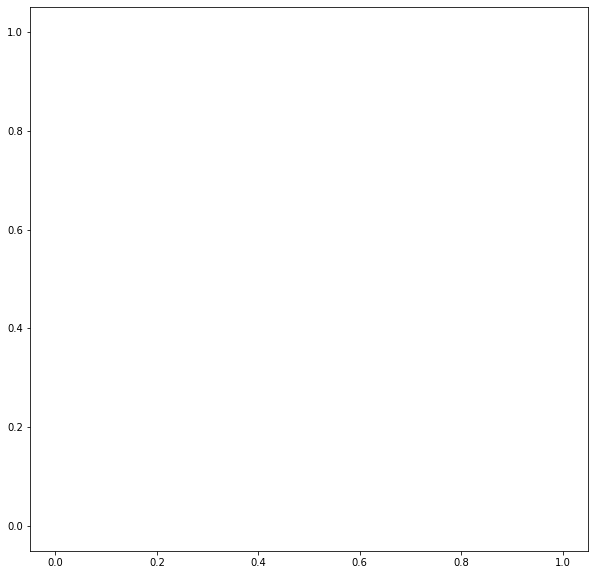

<Figure size 432x288 with 0 Axes>

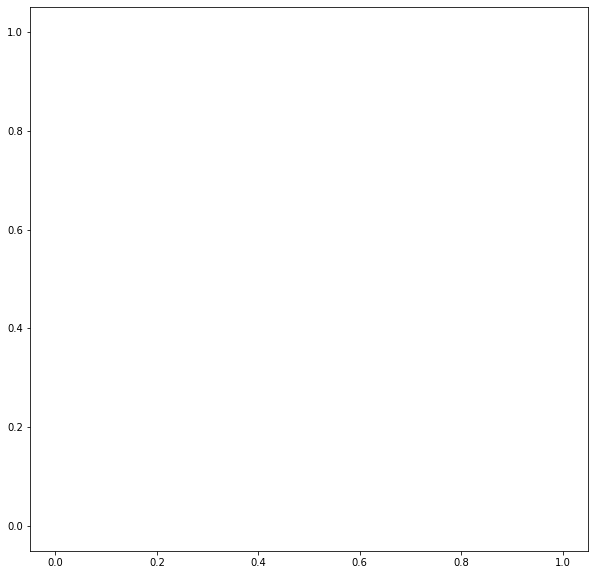

<Figure size 432x288 with 0 Axes>

In [125]:
for formation in strat_order:
    plt.figure(figsize=(10,10))
    subpreds = predictions[predictions['Formation'] == formation]
    plt.scatter(subpreds.Easting, subpreds.Northing, c=subpreds[0], cmap='viridis', alpha=0.5)#, vmin=0, vmax=7000)
    plt.show()
    plt.clf()

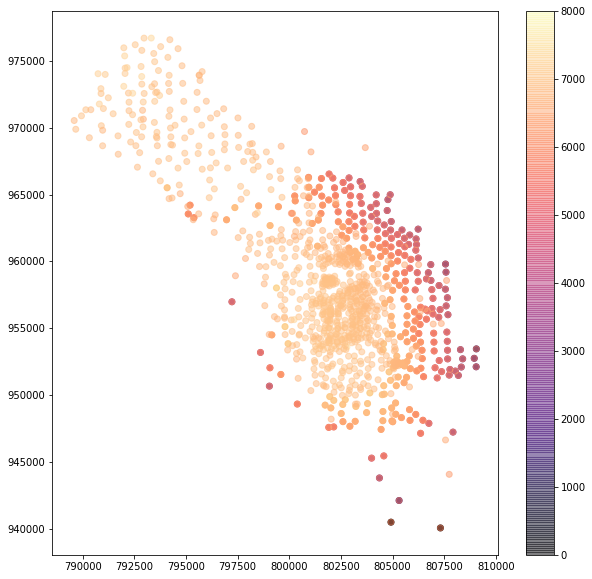

In [96]:
plt.figure(figsize=(10,10))
plt.scatter(subset.Easting, subset.Northing, c=subset.SS, cmap='magma')
plt.scatter(subpreds.Easting, subpreds.Northing, c=subpreds[0], cmap='magma', alpha=0.5, vmin=0, vmax=8000)
#plt.scatter(subpreds[subpreds[0]<0].Easting, subpreds[subpreds[0]<0].Northing, c='green')
plt.colorbar()

In [137]:
de_error = []
for i in np.arange(0.01, 1, 0.1):
    train, test = sample_splitter(tops, i, 86)
    print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')
    D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
    R = D_df.values
    from sklearn.preprocessing import binarize
    A = binarize(R) 
    U, Vt = runALS(R, A, 3, 20, 0.1)
    recommendations = np.dot(U, Vt) #get the recommendations
    recsys = pd.DataFrame(
        data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
    ) #results
    newDF = recsys.T
    newDF.reset_index(inplace=True)
    #test = newDF[["FORT UNION", "API"]]
    flat_preds = pd.DataFrame(recsys.unstack()).reset_index()
    new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])
    new_df.rename(columns={0:'SS_pred'}, inplace=True)
    cleanDF = new_df.dropna()
    cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])
    de_error.append(MSE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

Training size is 6608 tops, and test size is 67 tops
Initiating 
Training size is 5941 tops, and test size is 734 tops
Initiating 


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 5273 tops, and test size is 1402 tops
Initiating 


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 4606 tops, and test size is 2069 tops
Initiating 


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3938 tops, and test size is 2737 tops
Initiating 


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training size is 3271 tops, and test size is 3404 tops
Initiating 


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(0.01, 1, 0.1), de_error)

### Now let's hold out one well and slowly add in tops for it

In [197]:
tops[tops.API == tops.API.unique()[100]]

API Formation       MD       SS
856  490251078000      StFT  1070.87  5671.21
857  490251078000    NBRRws  1857.58  4884.50
858  490251078000    NBRRsg  2079.67  4662.41
859  490251078000     SHNNl   398.50  6343.58
860  490251078000    SHNNbs   479.41  6262.67
861  490251078000     SHNNu   308.99  6433.09
862  490251078000      CRLL  2295.18  4446.90
863  490251078000      StAM  1719.33  5022.75
864  490251078000      StGD  1619.39  5122.69
865  490251078000      StBR   683.49  6058.59

In [220]:
len(tops.API.unique())

1031

In [246]:
ssmin = tops.SS.min()
tops.SS = tops.SS - ssmin #standardize the subsea values
from sklearn.metrics import mean_absolute_error as MSE

tops.dropna(inplace=True)

def well_sample_splitter(dataframe, master_dataframe, number_of_tops, randomseed):
    test = dataframe.sample(n=number_of_tops, random_state=randomseed)
    test_idx = test.index.values
    train =  master_dataframe.drop(test_idx)
    return train, test

well_errors = []
for well in range(100):
    moving_well = tops[tops.API == tops.API.unique()[well]]
    errors = []
    for i in range(1, moving_well.shape[0], 1):

        train, test = well_sample_splitter(moving_well, tops, i, 86)

        #print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

        D_df = train.pivot_table("SS", "Formation", "API").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        from sklearn.preprocessing import binarize
        A = binarize(R) 
        U, Vt = runALS(R, A, 3, 20, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(test, flat_preds,  how='left', left_on=['API','Formation'], right_on = ['API','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['SS'] - cleanDF['SS_pred'])

        errors.append(MSE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))
    print(f'Done with {well+1} wells')
    well_errors.append(errors)

Done with 1 wells
Done with 2 wells
Done with 3 wells
Done with 4 wells
Done with 5 wells
Done with 6 wells
Done with 7 wells
Done with 8 wells
Done with 9 wells
Done with 10 wells
Done with 11 wells
Done with 12 wells
Done with 13 wells
Done with 14 wells
Done with 15 wells
Done with 16 wells
Done with 17 wells
Done with 18 wells
Done with 19 wells
Done with 20 wells
Done with 21 wells
Done with 22 wells
Done with 23 wells
Done with 24 wells
Done with 25 wells
Done with 26 wells
Done with 27 wells
Done with 28 wells
Done with 29 wells
Done with 30 wells
Done with 31 wells
Done with 32 wells
Done with 33 wells
Done with 34 wells
Done with 35 wells
Done with 36 wells
Done with 37 wells
Done with 38 wells
Done with 39 wells
Done with 40 wells
Done with 41 wells
Done with 42 wells
Done with 43 wells
Done with 44 wells
Done with 45 wells
Done with 46 wells
Done with 47 wells
Done with 48 wells
Done with 49 wells
Done with 50 wells
Done with 51 wells
Done with 52 wells
Done with 53 wells
Do

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Done with 93 wells
Done with 94 wells
Done with 95 wells
Done with 96 wells
Done with 97 wells
Done with 98 wells
Done with 99 wells
Done with 100 wells


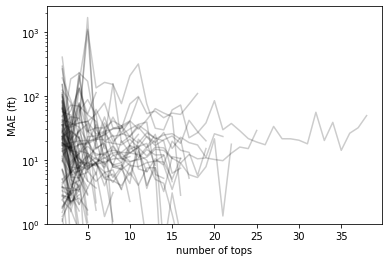

In [269]:
for i in range(len(well_errors)):
    plt.plot(range(len(well_errors[i])+1, 1,-1), well_errors[i], c='k', alpha=0.2)
    plt.xlabel('number of tops')
    plt.ylabel('MAE (ft)')
    plt.ylim(1,2500)
    plt.semilogy()


[]

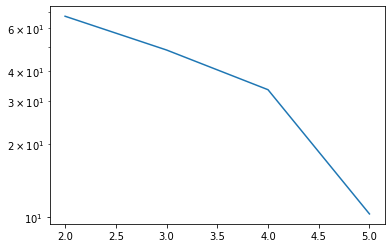

In [266]:
plt.plot(range(len(well_errors[2])+1, 1, -1), np.cumsum(well_errors[2]))
plt.semilogy()

# Norway below

In [313]:
norway_locs = pd.read_csv(r'E:\UT Austin\Datasets\RecSys\Norway\NPD stratigraphic picks north sea.csv')

In [314]:
norway_locs.head()

Unnamed: 0 Well identifier               Surface          X           Y  \
0       21675          10/4-1  CROMER KNOLL GP. Top  628531.41  6394710.62   
1       21660          10/4-1        Roedby Fm. Top  628531.41  6394710.62   
2       21656          10/4-1          Sola Fm. Top  628531.47  6394710.62   
3       21664          10/4-1       Aasgard Fm. Top  628531.50  6394710.61   
4       21668          10/4-1      VESTLAND GP. Top  628531.27  6394713.59   

         Z      MD  Geological age  TVT  TST  ... Unnamed: 28  Unnamed: 29  \
0 -1350.90  1382.0            4.21  NaN  NaN  ...         NaN          NaN   
1 -1350.90  1382.0           98.90  NaN  NaN  ...         NaN          NaN   
2 -1381.90  1413.0          102.50  NaN  NaN  ...         NaN          NaN   
3 -1397.90  1429.0          117.00  NaN  NaN  ...         NaN          NaN   
4 -2242.88  2274.0            1.00  NaN  NaN  ...         NaN          NaN   

   Unnamed: 30  Unnamed: 31  Unnamed: 32  Unnamed: 33  Unnamed: 34  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 35  Unnamed: 36  Unnamed: 37  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 38 columns]

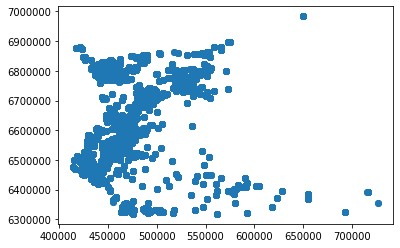

In [315]:
plt.scatter(norway_locs.X, norway_locs.Y)